# Final Year Project code

This is the jupyter notebook software (code) used towards my research project and it is structured in the following way

1. Imports 
2. Load and play with the dataset
3. Object detection - two experiments and application of Detectron2
4. Regression for weight detection - one experiment and RESNET50 application

Eugen Iordanescu - B815711

###Imports

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

from platform import python_version
import glob
from skimage import io

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import os, sys
import cv2

### Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/food_data.zip', 'r')
zip_ref.extractall('/Dataset') #Will unzip the images in the tmp folder
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/food_data_split.zip', 'r')
zip_ref.extractall('/Dataset') #Will unzip the images in the tmp folder
zip_ref.close()

In [4]:
len(os.listdir('/Dataset/food_data/train/'))
#get the training data images number

11021

In [5]:
len(os.listdir('/Dataset/food_data/test/'))
#get the testing data images number

3885

In [4]:
images_train_nonsplit = os.listdir('/Dataset/food_data/train/')
fruit_type = []
weight = []

for i in images_train_nonsplit:
    fruit_type.append(int(i[0]))
    temps=i[2:]
    temps=temps[temps.find('_')+1:] #the second '_'
    temps=temps[0:temps.find('_')]
    weight.append(int(temps))

for x in range(100):
    print(images_train_nonsplit[x])
    print(fruit_type[x])
    print(weight[x])


2_banana_747_0495.jpg
2
747
3_orange_532_0885.jpg
3
532
4_potato_72_0405.jpg
4
72
1_apple_510_1005.jpg
1
510
4_potato_161_0840.jpg
4
161
3_orange_912_1725.jpg
3
912
1_apple_1356_0735.jpg
1
1356
1_apple_306_1395.jpg
1
306
3_orange_1004_0645.jpg
3
1004
2_banana_289_0795.jpg
2
289
5_tomato_61_1425.jpg
5
61
5_tomato_331_2025.jpg
5
331
6_watermelon_740_1410.jpg
6
740
4_potato_18_1230.jpg
4
18
6_watermelon_344_1410.jpg
6
344
1_apple_634_1095.jpg
1
634
3_orange_1069_0360.jpg
3
1069
1_apple_1462_1560.jpg
1
1462
1_apple_634_1230.jpg
1
634
6_watermelon_740_0075.jpg
6
740
2_banana_1553_1455.jpg
2
1553
3_orange_222_0840.jpg
3
222
4_potato_143_1335.jpg
4
143
4_potato_57_0165.jpg
4
57
6_watermelon_740_0660.jpg
6
740
3_orange_1004_0705.jpg
3
1004
4_potato_72_0540.jpg
4
72
3_orange_145_0210.jpg
3
145
1_apple_206_1530.jpg
1
206
3_orange_1152_0060.jpg
3
1152
2_banana_833_0435.jpg
2
833
6_watermelon_563_0585.jpg
6
563
2_banana_432_1290.jpg
2
432
4_potato_131_0645.jpg
4
131
1_apple_847_1560.jpg
1
847
1_ap

###Data, preliminary analysis and pre-processing



In [5]:
dataset_train_path = '/Dataset/food_data_split/train/'
fruits_class = ['apple', 'banana', 'orange', 'potato', 'tomato', 'watermelon']

fruits_path = os.path.join(dataset_train_path, fruits_class[0], '*')
fruits_path = glob.glob(fruits_path)


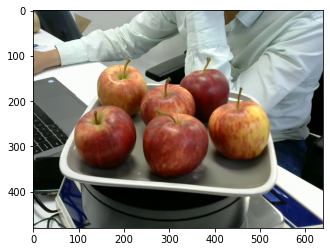

In [6]:
# accessing an image file from the dataset classes

image = io.imread(fruits_path[1311])


# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

Text(0.5, 0.98, 'Different Channels of Image')

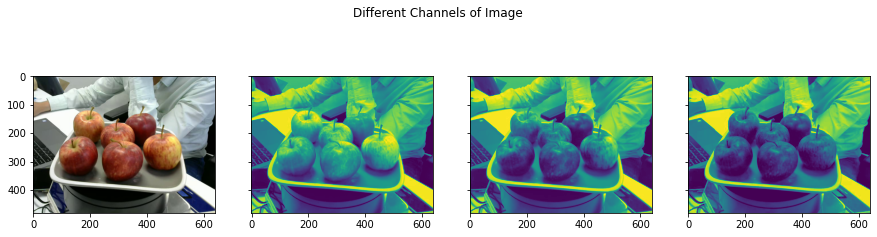

In [7]:
# play with colors

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

ax2.imshow(image[:, : , 0]) 
ax3.imshow(image[:, : , 1]) 
ax4.imshow(image[:, : , 2]) 
f.suptitle('Different Channels of Image')

# Load the data 


In [21]:
# Load Data Function
def load_data(img_folder):
    """Load dataset."""
    class_index = 0
    IMAGE_SIZE = 32

    X_data = []
    y_data = []
    dirs = [path for path in os.listdir(img_folder) if path != '.DS_Store']
    for dir1 in dirs:
        files = os.listdir(os.path.join(img_folder, dir1))
        for file in files:
            image_path = os.path.join(img_folder, dir1, file)

            # Read Image as numbers
            image = cv2.imread(image_path)
            
            # Resize the images
            try:
                image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                
            except:
              break
            # image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            
            # Rescale the images
            image = image / 255.0

            X_data.append(image)
            y_data.append(class_index)

        class_index += 1

    # Shuffle the dataset
    temp = list(zip(X_data, y_data))
    random.shuffle(temp)
    X_data, y_data = zip(*temp)

    # Convert list into numpy array
    X_data = np.asarray(X_data, dtype="float32")
    y_data = np.asarray(y_data, dtype="int32")
    
    return X_data, y_data

In [8]:
def load_data_nonsplit(img_folder):
    """Load dataset."""

    IMAGE_SIZE = 32

    X_data = []
    y_data = []
    
    files = os.listdir(os.path.join(img_folder))     
    for file in files:
        image_path = os.path.join(img_folder, file)
        class_index = int(file[0]) - 1
        # Read Image as numbers
        image = cv2.imread(image_path)
        
        # Resize the images
        try:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            
        except:
          break
        
        # Rescale the images
        image = image / 255.0

        X_data.append(image)
        y_data.append(class_index)

    # Shuffle the dataset
    temp = list(zip(X_data, y_data))
    random.shuffle(temp)
    X_data, y_data = zip(*temp)

    # Convert list into numpy array
    X_data = np.asarray(X_data, dtype="float32")
    y_data = np.asarray(y_data, dtype="int32")
    
    return X_data, y_data

In [9]:
def load_data_nonsplitexp2(img_folder):
    """Load dataset."""

    IMAGE_SIZE = 128

    X_data = []
    y_data = []
    
    files = os.listdir(os.path.join(img_folder))     
    for file in files:
        image_path = os.path.join(img_folder, file)
        class_index = int(file[0]) - 1
        # Read Image as numbers
        image = cv2.imread(image_path)
        
        # Resize the images
        try:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            
        except:
          break
        
        # Rescale the images
        image = image / 255.0

        X_data.append(image)
        y_data.append(class_index)

    # Shuffle the dataset
    temp = list(zip(X_data, y_data))
    random.shuffle(temp)
    X_data, y_data = zip(*temp)

    # Convert list into numpy array
    X_data = np.asarray(X_data, dtype="float32")
    y_data = np.asarray(y_data, dtype="int32")
    
    return X_data, y_data

In [12]:
# Numpy arrays experiment 1
X_train, y_train = load_data_nonsplit(img_folder='/Dataset/food_data/train')
X_test, y_test = load_data_nonsplit(img_folder='/Dataset/food_data/test')

In [10]:
# Numpy arrays experiment 2
X_train, y_train = load_data_nonsplitexp2(img_folder='/Dataset/food_data/train')
X_test, y_test = load_data_nonsplitexp2(img_folder='/Dataset/food_data/test')

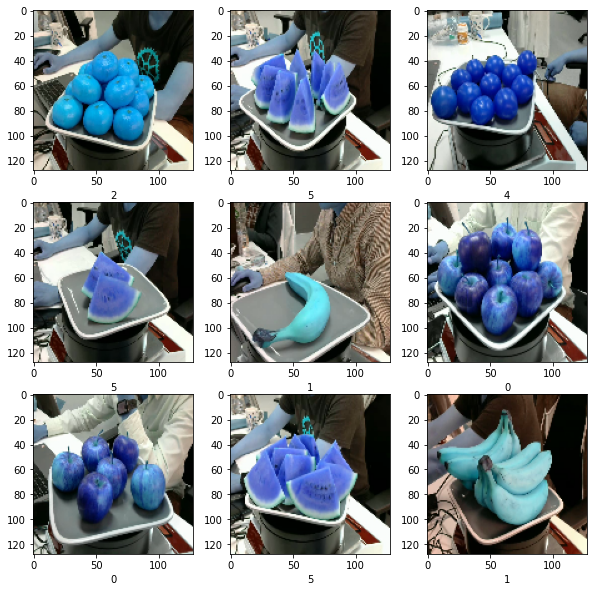

In [11]:
# Show the images

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.xlabel(y_train[i])
    plt.grid(False)
plt.show()
fig.savefig("./image.pdf")

In [12]:
# number of classes - 6 fruits
n_classes = 6

# one-hot encoding using keras' numpy utils functions
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

In [17]:
# This is related to the first experiment of object detection
# building a linear stack of layers with the sequential model (Experiment 1)
model1 = Sequential()

# convolutional layer
model1.add(Conv2D(75, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))

# convolutional layer
model1.add(Conv2D(125, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

# flatten output of convolutional layers
model1.add(Flatten())

# implementation of hidden layer
model1.add(Dense(500, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(250, activation='relu'))
model1.add(Dropout(0.3))

# implementation of output layer
model1.add(Dense(n_classes, activation='softmax'))

In [72]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 125)       84500     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 125)        0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 8, 8, 125)         0         
                                                                 
 flatten_6 (Flatten)         (None, 8000)             

In [18]:
# compiling the CNN model (Experiment 1)
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(0.0001))

# training the model for 10 epochs with batch size of 64
history1 = model1.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.3)

Epoch 1/10


ValueError: ignored

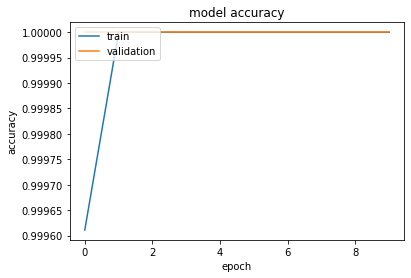

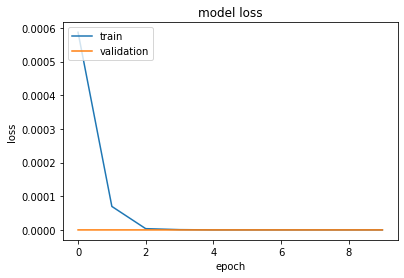

In [68]:
# summarize history1 for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history1 for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [74]:
# Evaluate results
results = model1.evaluate(x=X_test, y=y_test, batch_size=64)

61/61 [==============================] - 0s 5ms/step - loss: 1.6631e-08 - accuracy: 1.0000


In [13]:
# This is related to the second experiment in the report

# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# flatten output of convolutional layers
model.add(Flatten())

# implementation of hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# implementation of output layer
model.add(Dense(n_classes, activation='softmax'))

In [14]:
# compiling the CNN model (Experiment 2)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs with batch size of 64
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.3)

Epoch 1/10
121/121 [==============================] - 22s 92ms/step - loss: 0.3876 - accuracy: 0.9345 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/10
121/121 [==============================] - 10s 79ms/step - loss: 7.2124e-04 - accuracy: 0.9999 - val_loss: 1.2264e-05 - val_accuracy: 1.0000
Epoch 3/10
121/121 [==============================] - 11s 90ms/step - loss: 2.2789e-04 - accuracy: 1.0000 - val_loss: 1.8703e-04 - val_accuracy: 1.0000
Epoch 4/10
121/121 [==============================] - 10s 79ms/step - loss: 2.8527e-04 - accuracy: 1.0000 - val_loss: 3.1286e-06 - val_accuracy: 1.0000
Epoch 5/10
121/121 [==============================] - 10s 80ms/step - loss: 1.3085e-04 - accuracy: 1.0000 - val_loss: 1.1327e-06 - val_accuracy: 1.0000
Epoch 6/10
121/121 [==============================] - 10s 80ms/step - loss: 5.9264e-05 - accuracy: 1.0000 - val_loss: 9.1363e-07 - val_accuracy: 1.0000
Epoch 7/10
121/121 [==============================] - 11s 91ms/step - loss: 1.7628e-04 - accurac

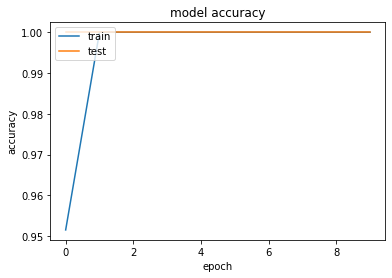

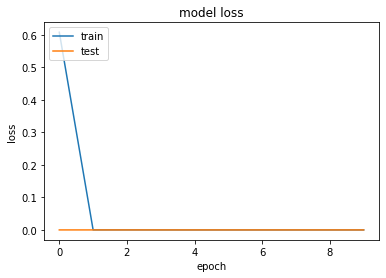

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# Evaluate the results

results2 = model.evaluate(x=X_test, y=y_test, batch_size=16)

243/243 [==============================] - 2s 9ms/step - loss: 1.9177e-07 - accuracy: 1.0000


In [16]:
convert_y = lambda y: [np.argmax(y_data) for y_data in y]

In [17]:
# get and print the confusion matrix
y_pred = model.predict(X_test)
conf_matrix = tf.math.confusion_matrix(convert_y(y_test), convert_y(y_pred), n_classes)
print (conf_matrix)

tf.Tensor(
[[630   0   0   0   0   0]
 [  0 270   0   0   0   0]
 [  0   0 720   0   0   0]
 [  0   0   0 668   0   0]
 [  0   0   0   0 652   0]
 [  0   0   0   0   0 945]], shape=(6, 6), dtype=int32)


# Detectron2 


In [4]:
# install requirements

!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 28.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=5daf6cc7879cc96e905c222d7971591ba686ce2b2b7a117109af8de6797b6dbf
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/

In [6]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [7]:
# Setup detectron2 logger, and other detectron2 librraries
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Register the data to Detectron2

In [8]:
from detectron2.structures import BoxMode

def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 480
        record["width"] = 640
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
        

In [9]:
classes = ['apple', 'banana', 'orange', 'tomato', 'watermelon']
images_train_annotated = os.listdir('/content/drive/MyDrive/food_data_annotated')
data_path = '/content/drive/MyDrive/food_data_annotated/'

for d in ["train", "test"]:
  DatasetCatalog.register(
      "fruits2_" + d, 
      lambda d=d: get_data_dicts(data_path +d, classes)
  )
  MetadataCatalog.get("fruits2_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("fruits2_train")
    

# Training the Detectron2 Instance Segmentation Model


In [10]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fruits2_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 #LEARNING RATE
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 


In [12]:
# trainer function

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[10/13 14:59:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:17, 10.3MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [13]:
trainer.train()

[10/13 15:00:34 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/13 15:01:03 d2.utils.events]:  eta: 0:15:09  iter: 19  total_loss: 2.808  loss_cls: 1.836  loss_box_reg: 0.2552  loss_mask: 0.6953  loss_rpn_cls: 0.01902  loss_rpn_loc: 0.008324  time: 0.8983  data_time: 0.4587  lr: 4.9953e-06  max_mem: 2336M
[10/13 15:01:12 d2.utils.events]:  eta: 0:08:03  iter: 39  total_loss: 2.691  loss_cls: 1.687  loss_box_reg: 0.2677  loss_mask: 0.6883  loss_rpn_cls: 0.01597  loss_rpn_loc: 0.008416  time: 0.6632  data_time: 0.0068  lr: 9.9902e-06  max_mem: 2336M
[10/13 15:01:22 d2.utils.events]:  eta: 0:07:16  iter: 59  total_loss: 2.376  loss_cls: 1.435  loss_box_reg: 0.2418  loss_mask: 0.6762  loss_rpn_cls: 0.01857  loss_rpn_loc: 0.009671  time: 0.5898  data_time: 0.0069  lr: 1.4985e-05  max_mem: 2336M
[10/13 15:01:30 d2.utils.events]:  eta: 0:07:05  iter: 79  total_loss: 2.014  loss_cls: 1.053  loss_box_reg: 0.2751  loss_mask: 0.6598  loss_rpn_cls: 0.01972  loss_rpn_loc: 0.007566  time: 0.5536  data_time: 0.0060  lr: 1.998e-05  max_mem: 2337M
[10/13 15:01:

In [14]:
# predictor function

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("/Dataset/food_data/test", )
predictor = DefaultPredictor(cfg)

[10/13 15:09:06 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [15]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)


In [16]:
for d in random.sample(test_dataset_dicts, 8):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

<!-- REGRESSION -->


# regression

In [5]:
pip install -U image-classifiers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 


In [6]:
# prepare data for regression
def load_data_nonsplit_weights(img_folder):
    """Load dataset."""

    IMAGE_SIZE = 128

    X_data = []
    y_data = []
    # dirs = [path for path in os.listdir(img_folder) if path != '.DS_Store']
    # for img in dirs:
    files = os.listdir(os.path.join(img_folder))     
    for file in files:
        image_path = os.path.join(img_folder, file)
        weights = int(file.split('_')[-2])
        # Read Image as numbers
        image = cv2.imread(image_path)
        
        # Resize the images
        try:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            
        except:
          break
        # image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        
        # Rescale the images
        image = image / 255.0

        X_data.append(image)
        y_data.append(weights)

    # Shuffle the dataset
    temp = list(zip(X_data, y_data))
    random.shuffle(temp)
    X_data, y_data = zip(*temp)

    # Convert list into numpy array
    X_data = np.asarray(X_data, dtype="float32")
    y_data = np.asarray(y_data, dtype="int32")
    
    return X_data, y_data

In [7]:
# Load numpy arrays with the images
X_train_regr, y_train_regr = load_data_nonsplit_weights(img_folder='/Dataset/food_data/train')
X_test_regr, y_test_regr = load_data_nonsplit_weights(img_folder='/Dataset/food_data/test')

# Regression model

In [8]:
# The regression model

# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(1, ))

In [9]:
# compiling the regression model
model.compile(loss='mean_squared_error', metrics=['mae'], optimizer="Adam")
# model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])

# training the model for 10 epochs
history_regr = model.fit(X_train_regr, y_train_regr, batch_size=64, epochs=10, validation_split=0.3)

Epoch 1/10
121/121 [==============================] - 27s 96ms/step - loss: 76890.0312 - mae: 186.4619 - val_loss: 24449.0078 - val_mae: 98.8598
Epoch 2/10
121/121 [==============================] - 9s 78ms/step - loss: 18880.7930 - mae: 95.5253 - val_loss: 17297.5137 - val_mae: 100.1381
Epoch 3/10
121/121 [==============================] - 9s 78ms/step - loss: 9184.7207 - mae: 70.0771 - val_loss: 3766.0796 - val_mae: 45.9527
Epoch 4/10
121/121 [==============================] - 10s 79ms/step - loss: 7564.9785 - mae: 62.1620 - val_loss: 4532.2837 - val_mae: 49.9802
Epoch 5/10
121/121 [==============================] - 10s 79ms/step - loss: 7580.2363 - mae: 61.2630 - val_loss: 9639.2607 - val_mae: 76.8972
Epoch 6/10
121/121 [==============================] - 10s 79ms/step - loss: 7063.4639 - mae: 58.4957 - val_loss: 6842.0854 - val_mae: 65.1576
Epoch 7/10
121/121 [==============================] - 10s 80ms/step - loss: 6278.8457 - mae: 55.8697 - val_loss: 2665.6050 - val_mae: 39.5144
Ep

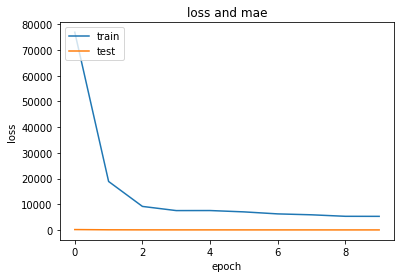

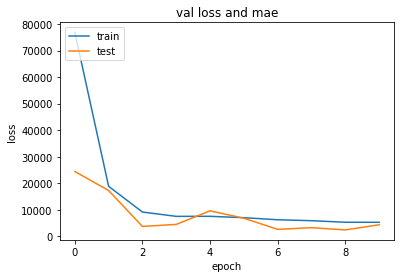

In [10]:
# summarize history for loss and mae
plt.plot(history_regr.history['loss'])
plt.plot(history_regr.history['mae'])
plt.title('loss and mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for val loss and val mae
plt.plot(history_regr.history['val_loss'])
plt.plot(history_regr.history['val_loss'])
plt.title('val loss and mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
results3 = model.evaluate(x=X_test_regr, y=y_test_regr, batch_size=16)

243/243 [==============================] - 2s 9ms/step - loss: 4471.5938 - mae: 53.4679


#Install resnet 


In [6]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 98.6 MB/s 
     |████████████████████████████████| 981 kB 56.7 MB/s 
     |████████████████████████████████| 263 kB 66.5 MB/s 
     |████████████████████████████████| 3.8 MB 46.1 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 468 kB 57.3 MB/s 
     |████████████████████████████████| 163 kB 53.3 MB/s 
     |████████████████████████████████| 7.6 MB 33.1 MB/s 
     |████████████████████████████████| 880 kB 55.1 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=a16b1ce2ac1f4b4e5c68d68229e4756a3f638a2534e8e0a352b5139a01568e61
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=9071eb8411e7a29d1a7875

In [7]:
import ktrain
from ktrain import vision as vis

In [6]:
vis.print_image_regression_models()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

In [8]:
# create pattern data

import re

pattern = r'\d_\w+_([\d]+)_\d+.jpg$'

p = re.compile(pattern)
r = p.search('1_apple_1053_0000.jpg')
print (r.group(1))

1053


In [9]:
DATADIR = '/Dataset/food_data/train'

In [10]:
(train_data, test_data, preproc) = vis.images_from_fname(DATADIR, pattern = pattern, is_regression = True, random_state = 42)

['label']
       label
6475   124.0
10594  124.0
9057   143.0
1183   118.0
3026   662.0


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:871: UserWarning: is_regression=True was supplied but targets are strings - casting to floats
  "is_regression=True was supplied but targets are strings - casting to floats"
/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:723: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  + "If this is incorrect, change accordingly."
/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:871: UserWarning: is_regression=True was supplied but targets are strings - casting to floats
  "is_regression=True was supplied but targets are strings - casting to floats"


['label']
        label
360       8.0
6273     85.0
10961   277.0
5945    186.0
10801  1069.0
Found 9918 validated image filenames.
Found 1103 validated image filenames.


In [12]:
 regr_model = vis.image_regression_model('pretrained_resnet50', train_data = train_data, val_data = test_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
94765736/94765736 [==============================] - 1s 0us/step
pretrained_resnet50 model created.


In [13]:
learner = ktrain.get_learner(model = regr_model, train_data = train_data, val_data = test_data, batch_size = 64)

In [18]:
regression_history = learner.fit_onecycle(1e-4, 10)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/10
155/155 [==============================] - 108s 686ms/step - loss: 70753.5547 - mae: 185.0784 - val_loss: 67763.2188 - val_mae: 180.4166
Epoch 2/10
155/155 [==============================] - 107s 691ms/step - loss: 63376.8477 - mae: 173.9277 - val_loss: 58415.3477 - val_mae: 166.0035
Epoch 3/10
155/155 [==============================] - 106s 681ms/step - loss: 52774.7617 - mae: 156.9196 - val_loss: 47323.7578 - val_mae: 146.8241
Epoch 4/10
155/155 [==============================] - 107s 691ms/step - loss: 41874.4922 - mae: 137.4322 - val_loss: 36653.0977 - val_mae: 126.8235
Epoch 5/10
155/155 [==============================] - 105s 679ms/step - loss: 31982.9941 - mae: 118.2692 - val_loss: 27502.4785 - val_mae: 107.7040
Epoch 6/10
155/155 [==============================] - 107s 690ms/step - loss: 24303.4395 - mae: 102.2379 - val_loss: 21234.1934 - val_mae: 95.3752
Epoch 7/10
155/155 [=============================

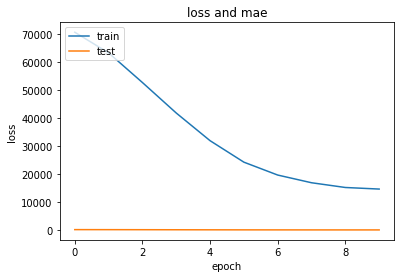

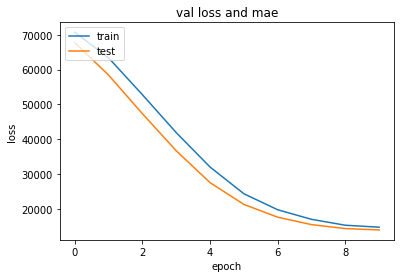

In [19]:
# summarize history for loss and mae
plt.plot(regression_history.history['loss'])
plt.plot(regression_history.history['mae'])
plt.title('loss and mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for val loss and val
plt.plot(regression_history.history['loss'])
plt.plot(regression_history.history['val_loss'])
plt.title('val loss and mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
results2 = model.evaluate(x=X_test, y=y_test, batch_size=16)

NameError: ignored

# Make Predictions

In [20]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [40]:
test_data.filenames[10:20]

['4_potato_28_0630.jpg',
 '6_watermelon_1037_1575.jpg',
 '3_orange_1152_1500.jpg',
 '5_tomato_506_0570.jpg',
 '1_apple_107_0045.jpg',
 '3_orange_295_0900.jpg',
 '3_orange_840_1410.jpg',
 '2_banana_662_0660.jpg',
 '1_apple_107_0135.jpg',
 '3_orange_71_0630.jpg']

In [21]:
def run_predictor(filename):
  filename = DATADIR + '/' + filename
  myPredictor = round(predictor.predict_filename(filename)[0])
  actual = int(p.search(filename).group(1))
  vis.show_image(filename)
  print ("The predicted weight: %s and Actual weight: %s" % (myPredictor, actual))

1/1 [==============================] - 0s 143ms/step
Predicted weight: 482 and Actual weight: 510


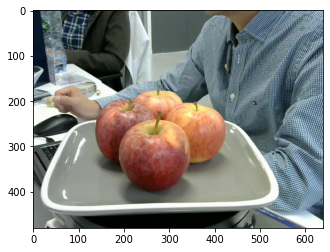

In [27]:
run_predictor('1_apple_510_0135.jpg')